# Capstone Project - Finding the Right Neighborhood to Open an Italian Restaurant

### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Collecting Toronto Neighborhood data](#demographics)
* [Collect Venue Information](#venues)
* [Map of Neighborhood Venues](#map)
* [Analysis](#analysis)
* [Clustering](#cluster)
* [Selected Neighbrhoods](#selected)

## Introduction: Business Problem <a name="introduction"></a>

My wife and I will be moving to Toronto shortly, and we would like to open an Italian restaurant. However, Toronto is a big city with many neighborhoods. How should we pick the right neighborhood to start our business?

To understand this problem, we have to set some metrics to define what makes a neighborhood ideal. For this, we have hypothesized the following:
1. Low percentage of Italian Restaurants
- In Canada, we believe that Italian food is very much a staple. Therefore, the lack of Italian restaurants in an area may not mean that it is undesirable. In fact, we expect that opening a restaurant in an area with few Italian restaurants may result in less competition and greater sales.

2. High salary of residents
- People with high salaries have the means of going out to eat. A restaurant in a more well-off area may be able to sustain higher prices for the food.

3. Population density
- If there are more people in a given neighborhood, then a given conversion percentage will result in more people eating at the restaurant.

4. Low average ratings of current Italian restaurants
- If there are multiple Italian restaurants in a neighborhood, people may look up ratings to decide where to get their food. Our restaurant may struggle more in a neighborhood that already has very highly rated Italian restaurants.

We will begin with data from Wikipedia on the different neighborhoods of Toronto. This will include the name of the neighborhood, population, land area, and average income. We will then extract latitude and longitude coordinates using geolocator. From the coordinates, we will retrieve information from FourSquare, including the number of restaurants, the percentage of Italian restaurants, and ratings of each Italian restaurant.

We will perform some regression statistics to determine if the demographic data can predict the percentage of Italian restaurants and average ratings.

We will also use machine learning to cluster some of the neighborhoods together, to allow greater numbers in each set.

Finally, we will suggest a few neighborhoods as potential key markets for opening up an Italian restaurant

## Collecting Toronto Neighborhood data <a name="demographics"></a>

Let's start by installing a few different libraries that we'll need and then importing all relevant libraries.

In [1]:
import sys
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge lxml --yes # uncomment this line if you haven't completed the Foursquare API lab
print("Libraries are loaded")

Libraries are loaded


In [48]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import lxml
import numpy as np
import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib as mpl
%matplotlib inline
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
import math
from math import radians, sin, cos, acos
import statistics
from sklearn.cluster import KMeans

We will read data from Wikipedia about the different neighborhoods in Toronto.

In [3]:
headers = ["Name", "FM", "CensusTracts", "Population", "LandArea", "Density", "PercentChangePopulation", "AverageIncome", "TransitCommuting", "PercentRenters", "OtherLanguage1", "OtherLanguage2", "Map"]
df1 = pd.read_html("https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods", skiprows=1, header=None,)
df = df1[0]
df.columns = headers
df = df[["Name", "Population", "LandArea", "PercentChangePopulation", "AverageIncome"]]

In [4]:
df.shape

(174, 5)

In [5]:
df.head()

,Name,Population,LandArea,PercentChangePopulation,AverageIncome
0,Agincourt,44577,12.45,4.6,25750
1,Alderwood,11656,4.94,-4.0,35239
2,Alexandra Park,4355,0.32,0.0,19687
3,Allenby,2513,0.58,-1.0,245592
4,Amesbury,17318,3.51,1.1,27546


Now we replace a couple neighborhood names with ones searchable by FourSquare

In [6]:
df["Name"].replace({"Distillery District/West Don Lands": "Distillery District", "Regent Park/Trefann Court": "Regent Park"}, inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Now we will generate latitude and longitude coordinates for the neighborhoods. We will then remove rows for neighborhoods that are not searchable within FourSquare and reset the index. We will also remove neighborhoods very far from the city centre of Toronto.

In [9]:
print(df.shape)
df["Latitude"] = float(0)
df["Longitude"] = float(0)
for i in range(df.shape[0]):  
    try:
        address = df.Name[i] + ", Ontario"
        geolocator = Nominatim(user_agent = "on_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        df.Latitude[i] = latitude
        df.Longitude[i] = longitude
    except:
        print(df.Name[i] + " is not found on FourSquare")
print(df.shape)

(174, 7)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in th

Humber Bay Shores is not found on FourSquare
Humbermede is not found on FourSquare
Humewood–Cedarvale is not found on FourSquare
Playter Estates is not found on FourSquare
Rockcliffe–Smythe is not found on FourSquare
Tam O'Shanter – Sullivan is not found on FourSquare
(174, 7)


In [10]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent = "on_explorer")
location = geolocator.geocode(address)
latitudeToronto = location.latitude
longitudeToronto = location.longitude
print("The geographic coordinate of Toronto are {}, {}." .format(latitudeToronto, longitudeToronto))

The geographic coordinate of Toronto are 43.6534817, -79.3839347.


In [11]:
df["DistanceCityCentre"] = 0.0
startLat = radians(float(latitudeToronto))
startLon = radians(float(longitudeToronto))
for i in range(df.shape[0]):
    endLat = radians(float(df.Latitude[i]))
    endLon = radians(float(df.Longitude[i]))
    df.DistanceCityCentre[i] = 6371.01 * acos(sin(startLat)*sin(endLat) + cos(startLat)*cos(endLat)*cos(startLon - endLon))

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
df = df[df.Latitude != 0]

In [13]:
df = df[df.DistanceCityCentre < 20]

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
df.head()

,Name,Population,LandArea,PercentChangePopulation,AverageIncome,Latitude,Longitude,DistanceCityCentre
0,Agincourt,44577,12.45,4.6,25750,43.785353,-79.278549,16.933531
1,Alderwood,11656,4.94,-4.0,35239,43.601717,-79.545232,14.201221
2,Alexandra Park,4355,0.32,0.0,19687,43.650758,-79.404308,1.666843
3,Amesbury,17318,3.51,1.1,27546,43.706162,-79.483492,9.920269
4,Armour Heights,4384,2.29,2.0,116651,43.743944,-79.430851,10.742798


## Collect Venue Information <a name="demographics"></a>

Here we define two functions for extracting some information about each venue.

The first function will access details from FourSquare regarding all restaurant venues that fall within a set radius of each neighborhood (determined by the square area and coordinates). Here, we approximate the area as a circle, which does introduce a bit of error, but it should be fine for our purposes.

The second function is used to extract a few key parameters for each neighborhood. Specifically, we care about the total number of restaurants and also the number of those that fall into the category of Italian (namely, Italian Restaurant and Pizza Place). For each Italian restaurant with 5 or more reviews, we will record the score. We then determine the average and max score for that neighborhood's Italian venues.

In [16]:
def GetFourSquare(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
    venueResults = requests.get(url).json()
    venues = venueResults['response']['groups'][0]['items']
    nearby_venues = pd.json_normalize(venues)
    filtered_columns = ["venue.id", "venue.name", "venue.location.distance", "venue.categories"]
    dataframe_filtered = nearby_venues.loc[:, filtered_columns]
    dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]
    return dataframe_filtered

In [17]:
def GetRRs(dataframe_filtered, restaurants):
    ratings = []
    for j in range(dataframe_filtered.shape[0]):
        restaurantCategory = dataframe_filtered["categories"].loc[j]
        categoryName = restaurantCategory[0]
        restaurants.append(categoryName["name"])
        # To get ratings for venue IDs
        if categoryName["name"] == "Italian Restaurant" or categoryName["name"] == "Pizza Place":
            try:
                venue_id = dataframe_filtered.id[j]
                url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
                ratingResults = requests.get(url).json()
                #print(result['response']['venue'].keys())
                RestaurantRating = ratingResults['response']['venue']['rating']
                RestaurantNumberRatings = ratingResults["response"]["venue"]["ratingSignals"]
                if RestaurantNumberRatings > 4:
                    ratings.append(RestaurantRating)
            except:
                pass
    return [restaurants, ratings]

Now that we have our functions defined, we will input our FourSquare credentials and populate our dataframe with the parameters.

In [18]:
CLIENT_ID = 'HIDDEN' # your Foursquare ID
CLIENT_SECRET = 'HIDDEN' # your Foursquare Secret
VERSION = '20200526'
search_query = "Restaurant"
LIMIT = 100
df["NumberRestaurants"] = 0
df["NumberItalianRestaurants"] = 0
df["AverageRating"] = 0.0
df["MaxRating"] = 0.0

for i in range(df.shape[0]):
    restaurants = []
    try:
        latitude = df.Latitude[i]
        longitude = df.Longitude[i]
        radius = math.sqrt(df.LandArea[i])*500
        df_temp = GetFourSquare(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        df_temp2, df_temp3 = GetRRs(df_temp, restaurants)
        italianPlaces = restaurants.count("Italian Restaurant") + restaurants.count("Pizza Place")
        df.NumberRestaurants[i] = len(restaurants)
        df.NumberItalianRestaurants[i] = italianPlaces
        df.AverageRating[i] = statistics.mean(df_temp3)
        df.MaxRating[i] = max(df_temp3)
        
    except:
        print(df.Name[i], "has no Italian restaurants with 5 or more ratings")

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jupyterlab/conda/envs/python/lib/p

Bay Street Corridor has no Italian restaurants with 5 or more ratings
Bayview Woods – Steeles has no Italian restaurants with 5 or more ratings
Bedford Park has no Italian restaurants with 5 or more ratings
Birch Cliff has no Italian restaurants with 5 or more ratings
Bracondale Hill has no Italian restaurants with 5 or more ratings
Brockton has no Italian restaurants with 5 or more ratings
Carleton Village has no Italian restaurants with 5 or more ratings
Casa Loma has no Italian restaurants with 5 or more ratings
Christie Pits has no Italian restaurants with 5 or more ratings
Clairlea has no Italian restaurants with 5 or more ratings
Cliffcrest has no Italian restaurants with 5 or more ratings
Cliffside has no Italian restaurants with 5 or more ratings
Corktown has no Italian restaurants with 5 or more ratings
Crescent Town has no Italian restaurants with 5 or more ratings
Davenport has no Italian restaurants with 5 or more ratings
Don Mills has no Italian restaurants with 5 or more 

Now let's take a look at our updated dataframe.

In [21]:
df.head()

,Name,Population,LandArea,PercentChangePopulation,AverageIncome,Latitude,Longitude,DistanceCityCentre,NumberRestaurants,NumberItalianRestaurants,AverageRating,MaxRating
0,Agincourt,44577,12.45,4.6,25750,43.785353,-79.278549,16.933531,67,6,6.00,6.2
1,Alderwood,11656,4.94,-4.0,35239,43.601717,-79.545232,14.201221,12,4,7.90,8.2
2,Alexandra Park,4355,0.32,0.0,19687,43.650758,-79.404308,1.666843,13,2,7.25,7.5
3,Amesbury,17318,3.51,1.1,27546,43.706162,-79.483492,9.920269,12,2,6.60,6.6
4,Armour Heights,4384,2.29,2.0,116651,43.743944,-79.430851,10.742798,5,2,6.80,6.8


Now we can make a map of Toornto using Folium. We will place labels on the map that correspond to the area of each neighborhood. Remember that we are approximating the area with a circle. We will include the number of Italian restaurants and average rating on each label.

## Map of Neighborhood Venues <a name="map"></a>

In [22]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent = "on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("The geographic coordinate of Toronto are {}, {}." .format(latitude, longitude))

The geographic coordinate of Toronto are 43.6534817, -79.3839347.


In [73]:
map_toronto = folium.Map(location = [latitude, longitude], zoom_start = 11)

# add markers to map
for lat, lng, neighborhood, area, number, rating in zip(df["Latitude"], df["Longitude"], df["Name"], df["LandArea"], df["NumberItalianRestaurants"], df["AverageRating"]):
    rating = round(rating, 1)
    label = "{}, {} Italian restaurants, {} average rating".format(neighborhood, number, rating)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius = math.sqrt(area)*500,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

## Analysis <a name="analysis"></a>

Now let's first count how many Italian restaurants we have for the neighborhoods.

In [35]:
print("There are ", sum(df.NumberItalianRestaurants), "Italian restaurants")
df.sort_values(by="NumberItalianRestaurants", ascending=False).head()

There are  402 Italian restaurants


,Name,Population,LandArea,PercentChangePopulation,AverageIncome,Latitude,Longitude,DistanceCityCentre,NumberRestaurants,NumberItalianRestaurants,AverageRating,MaxRating
102,Princess Gardens,9288,4.13,1.0,80607,43.640466,-79.391224,1.561557,100,18,7.829412,8.7
79,Little Italy,7917,0.81,-6.1,31231,43.655208,-79.414877,2.496738,60,14,6.833333,8.3
78,Leslieville,23567,2.69,-7.3,30886,43.662700,-79.332815,4.238242,64,12,7.266667,9.2
45,Fashion District,4642,0.98,123.0,63282,43.645456,-79.394994,1.260231,70,12,7.691667,8.7
57,Harbourfront / CityPlace,14368,1.87,94.3,69232,43.640080,-79.380150,1.520997,74,11,6.911111,7.7


Let's check to see if any parameters can predict the percentage of Italian restaurants

Text(0, 0.5, 'Percentage of Italian Restaurants')

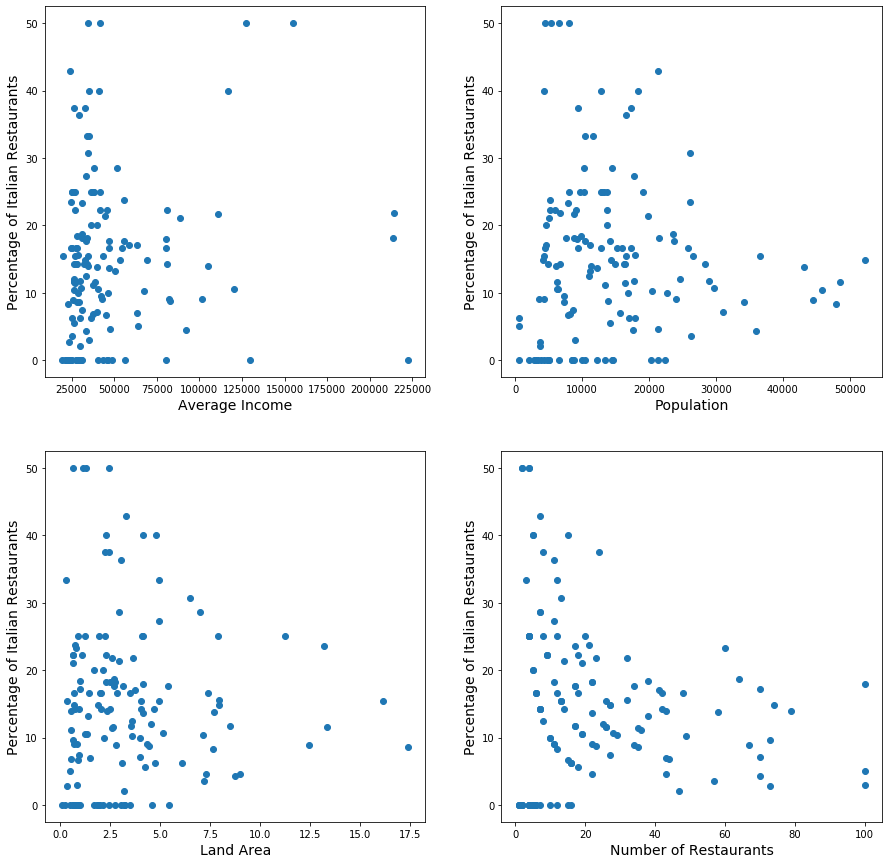

In [43]:
italianPercentage = df.NumberItalianRestaurants / df.NumberRestaurants * 100

fig = mpl.pyplot.figure(figsize=(15, 15))
fig.figsize = (10, 10)
ax = fig.add_subplot(2, 2, 1)
ax.scatter(df.AverageIncome, italianPercentage)
ax.set_ylabel("Percentage of Italian Restaurants", fontsize = 14)
ax.set_xlabel("Average Income", fontsize = 14)
ax2 = fig.add_subplot(2, 2, 2)
ax2.scatter(df.Population, italianPercentage)
ax2.set_xlabel("Population", fontsize = 14)
ax2.set_ylabel("Percentage of Italian Restaurants", fontsize = 14)
ax3 = fig.add_subplot(2, 2, 3)
ax3.scatter(df.LandArea, italianPercentage)
ax3.set_xlabel("Land Area", fontsize = 14)
ax3.set_ylabel("Percentage of Italian Restaurants", fontsize = 14)
ax4 = fig.add_subplot(2, 2, 4)
ax4.scatter(df.NumberRestaurants, italianPercentage)
ax4.set_xlabel("Number of Restaurants", fontsize = 14)
ax4.set_ylabel("Percentage of Italian Restaurants", fontsize = 14)

We can see from the above graphs that none of the features really have a large effect on the percentage of total Italian restaurants. Even the total number of restaurants, which appears to have a trend, is really due to diverging percentages at low number of restaurants (i.e. poor sampling).

Now let's do the same thing for average rating of Italian restaurants. We will exclude neighborhoods with no recorded ratings.

Text(0, 0.5, 'Average Rating of Italian Restaurants')

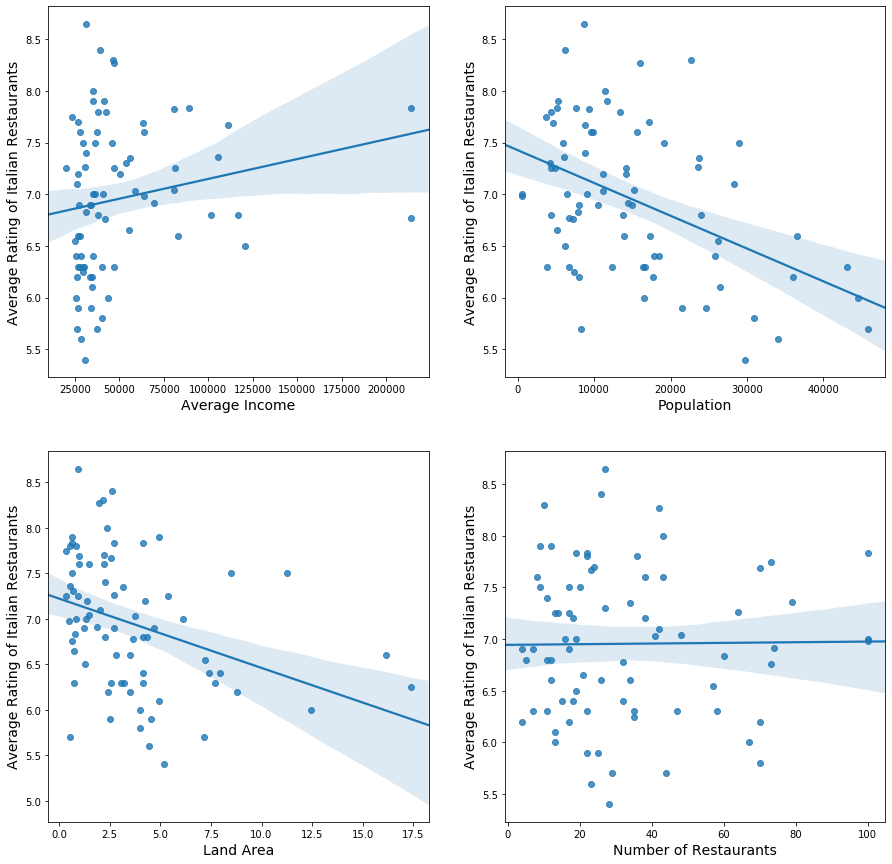

In [53]:
df_rating = df[df.AverageRating != 0]

fig = mpl.pyplot.figure(figsize=(15, 15))
fig.figsize = (10, 10)
ax = fig.add_subplot(2, 2, 1)
ax = sns.regplot(df_rating.AverageIncome, df_rating.AverageRating)
ax.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax.set_xlabel("Average Income", fontsize = 14)
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.regplot(df_rating.Population, df_rating.AverageRating)
ax2.set_xlabel("Population", fontsize = 14)
ax2.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.regplot(df_rating.LandArea, df_rating.AverageRating)
ax3.set_xlabel("Land Area", fontsize = 14)
ax3.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.regplot(df_rating.NumberRestaurants, df_rating.AverageRating)
ax4.set_xlabel("Number of Restaurants", fontsize = 14)
ax4.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)

Here, at least, population and land area appear to be somewhat inversely related to average rating of Italian restaurants within a given neighborhood. Average income and total number of restaurants appear to have no real effect. This allows average income to be an independent variable along with the percentage of Italian restaurants.

## Clustering <a name="cluster"></a>

Although Average Rating does seem like it can be marginally predicted based on the parameters above, let's see if the prediction data is suffering for under-sampling. We will use some machine learning, namely K Clustering. We will separate the neighborhoods into seven different clusters and then see if the Average Rating scales with the parameters. Maybe the increased number of restaurants in each cluster will help.

In [65]:
kclusters = 7

df_clustering = df_rating[["Latitude", "Longitude"]]
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(df_clustering)

kmeans.labels_[0:10]

array([6, 3, 0, 2, 5, 5, 1, 6, 2, 5], dtype=int32)

In [72]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster, area in zip(df_rating['Latitude'], df_rating['Longitude'], df_rating['Name'], kmeans.labels_, df_rating["LandArea"]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.Circle(
        [lat, lon],
        radius=math.sqrt(area)*500,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [70]:
df_rating["ClusteredList"] = kmeans.labels_
df_rating.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Name,Population,LandArea,PercentChangePopulation,AverageIncome,Latitude,Longitude,DistanceCityCentre,NumberRestaurants,NumberItalianRestaurants,AverageRating,MaxRating,ClusteredList
0,Agincourt,44577,12.45,4.6,25750,43.785353,-79.278549,16.933531,67,6,6.00,6.2,6
1,Alderwood,11656,4.94,-4.0,35239,43.601717,-79.545232,14.201221,12,4,7.90,8.2,3
2,Alexandra Park,4355,0.32,0.0,19687,43.650758,-79.404308,1.666843,13,2,7.25,7.5,0
3,Amesbury,17318,3.51,1.1,27546,43.706162,-79.483492,9.920269,12,2,6.60,6.6,2
4,Armour Heights,4384,2.29,2.0,116651,43.743944,-79.430851,10.742798,5,2,6.80,6.8,5


In [68]:
df_clustered = df_rating.groupby(by = "ClusteredList").mean()
df_clustered

,Population,LandArea,PercentChangePopulation,AverageIncome,Latitude,Longitude,DistanceCityCentre,NumberRestaurants,NumberItalianRestaurants,AverageRating,MaxRating
ClusteredList,,,,,,,,,,,
0,9006.560000,1.276000,12.520000,64616.400000,43.665744,-79.399392,2.532600,45.680000,5.560000,7.321033,7.900000
1,25999.714286,5.165714,5.042857,31361.857143,43.792296,-79.329652,16.140101,26.428571,2.857143,6.035714,6.128571
2,16024.333333,2.359167,-0.783333,37362.500000,43.664909,-79.464332,6.919244,25.333333,4.166667,7.129167,7.591667
3,11188.700000,5.559000,2.170000,44698.200000,43.634778,-79.532057,12.747779,17.500000,3.200000,7.166667,7.510000
4,15422.714286,2.974286,-2.971429,44971.428571,43.668176,-79.347283,3.905692,37.571429,4.571429,6.680952,7.157143
5,18572.900000,5.592000,8.430000,59502.700000,43.748546,-79.437136,11.541832,27.600000,3.600000,6.597500,6.790000
6,22362.571429,6.491429,5.457143,27665.571429,43.755039,-79.277053,14.333697,28.285714,3.285714,6.742857,6.785714


Text(0, 0.5, 'Average Rating of Italian Restaurants')

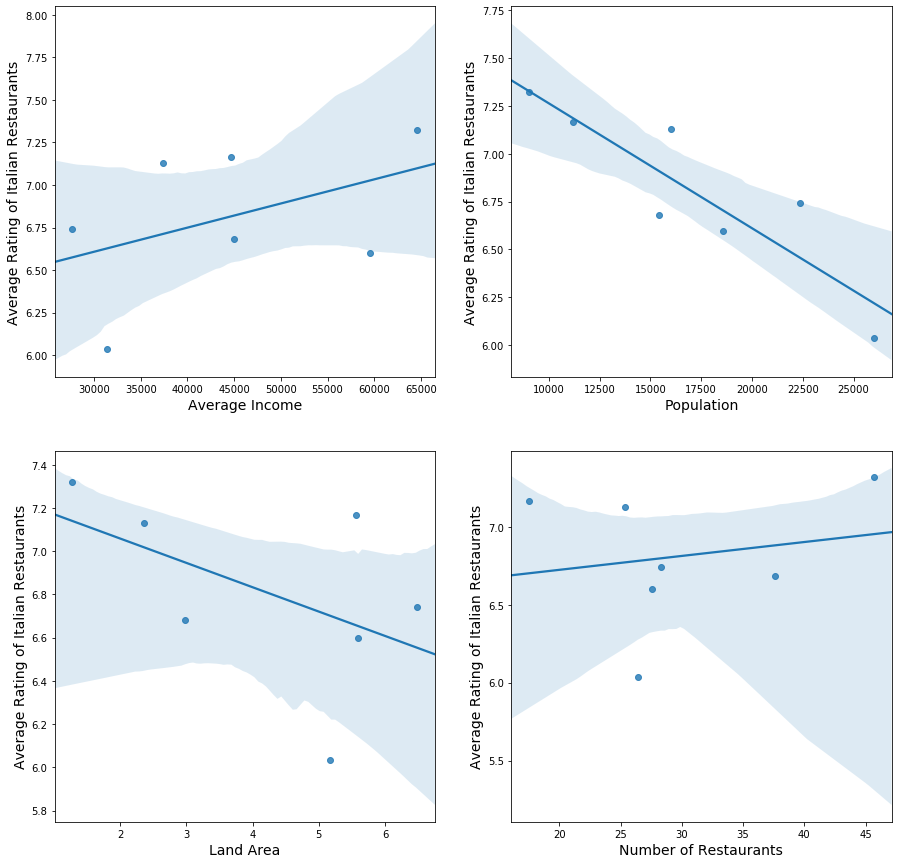

In [69]:
fig = mpl.pyplot.figure(figsize=(15, 15))
fig.figsize = (10, 10)
ax = fig.add_subplot(2, 2, 1)
ax = sns.regplot(df_clustered.AverageIncome, df_clustered.AverageRating)
ax.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax.set_xlabel("Average Income", fontsize = 14)
ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.regplot(df_clustered.Population, df_clustered.AverageRating)
ax2.set_xlabel("Population", fontsize = 14)
ax2.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.regplot(df_clustered.LandArea, df_clustered.AverageRating)
ax3.set_xlabel("Land Area", fontsize = 14)
ax3.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)
ax4 = fig.add_subplot(2, 2, 4)
ax4 = sns.regplot(df_clustered.NumberRestaurants, df_clustered.AverageRating)
ax4.set_xlabel("Number of Restaurants", fontsize = 14)
ax4.set_ylabel("Average Rating of Italian Restaurants", fontsize = 14)

## Selected Neighborhoods <a name="selected"></a>

Now we are going to use our given parameters to discover which neighborhoods are ideal. To do this, we will normalize the four feature columns. Then, we will give each restaurant an aggregated score for each parameter. The neighborhoods with the highest overall scores will be deemd ideal.

In [174]:
from sklearn import preprocessing

df["PopulationDensity"] = df["Population"] / df["LandArea"]
df["PercentItalian"] = df["NumberItalianRestaurants"] / df["NumberRestaurants"]
df_select = df[["PopulationDensity", "AverageIncome", "PercentItalian", "AverageRating"]]
df_select.head()
# Find statistical mean for the average rating for neighborhoods that have ratings.
df_mean = df_select[df_select.AverageRating != 0]
mean_rating = statistics.mean(df_mean["AverageRating"])
print(mean_rating)
df_select["AverageRating2"] = 0.0
for i in range(df_select.shape[0]):
    if df_select.AverageRating[i] == 0:
        df_select.AverageRating2[i] = mean_rating
    else:
        df_select.AverageRating2[i] = df_select.AverageRating[i]
df_select["AverageRating"] = df_select["AverageRating2"]
df_select.drop(["AverageRating2"], axis=1, inplace=True)
# Preprocess the data
x = df_select.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_select = pd.DataFrame(x_scaled)
df_select.columns = ["HighestPopulationDensity", "HighestAverageIncome", "LeastItalianRestaurants%", "LowestAverageRating"]
# Invert the numbers for PercentItalian and Average Rating since for these metrics, lower values are ideal.
df_select["LeastItalianRestaurants%"] = 1 - df_select["LeastItalianRestaurants%"]
df_select["LowestAverageRating"] = 1 - df_select["LowestAverageRating"]
df_select.head()
df_select["Score"] = df_select.sum(axis=1)
df_select["Name"] = df["Name"]

6.954284092813505


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

Now we will merge a few columns back into the dataframe and select the top 25 neighborhoods based on score.

We also want to add a stipulation that the population density and average income must at least both be above 0.1 in their individual score.

In [179]:
df_final = df_select.merge(df[["Name", "Latitude", "Longitude", "LandArea"]], on="Name")
#df_final = df_final.nlargest(25, "Score")
#df_final.head(25)
df_final = df_final[df_final["HighestPopulationDensity"] > 0.1]
df_final = df_final[df_final["HighestAverageIncome"] > 0.1]

df_final.sort_values(by = "Score", ascending=False)

,HighestPopulationDensity,HighestAverageIncome,LeastItalianRestaurants%,LowestAverageRating,Score,Name,Latitude,Longitude,LandArea
6,0.682008,0.103808,1.000000,0.521759,2.307575,Bay Street Corridor,43.664457,-79.387189,0.11
105,0.120581,0.101547,0.857143,0.876923,1.956194,Riverdale,43.665470,-79.352594,3.99
142,0.168066,0.422175,0.721519,0.395804,1.707564,Yorkville,43.671386,-79.390168,0.56
30,0.171339,0.110703,0.808219,0.581538,1.671799,Discovery District,43.657556,-79.389480,0.66
121,0.140223,0.125385,0.866667,0.521759,1.654033,The Danforth,43.686433,-79.300355,0.87
29,0.161664,0.301336,0.666667,0.495385,1.625051,Deer Park,43.688090,-79.394093,1.46
57,0.119203,0.244835,0.702703,0.535043,1.601783,Harbourfront / CityPlace,43.640080,-79.380150,1.87
119,0.165223,0.217274,0.860465,0.323077,1.566038,The Annex,43.670338,-79.407117,1.47
25,0.103640,0.173169,0.666667,0.521759,1.465234,Corktown,43.657370,-79.356513,0.67
16,0.123277,0.152074,0.736842,0.446154,1.458347,Cabbagetown,43.664473,-79.366986,1.40


Now let's throw these neighborhoods back up on the map to see where they are.

In [182]:
map_select = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, neighborhood, area, score in zip(df_final["Latitude"], df_final["Longitude"], df_final["Name"], df_final["LandArea"], df_final["Score"]):
    score = round(score, 1)
    label = "{}, {} score".format(neighborhood, score)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
        [lat, lng],
        radius = math.sqrt(area)*500,
        popup=label,
        color="blue",
        fill=True,
        fill_color="#3186cc",
        fill_opacity=0.7,
        parse_html=False).add_to(map_select)
    
map_select

Now we can see clearly where the top locations are on the map. One possibility would to just pick the neighborhood with the highest score. For our analysis, however, we kept all four metrics with equal weighting. This could easily be adjusted, depending on the specific case. However, one good idea would be to choose a neighborhood with a high score that is also close to other high score neighborhoods. Overall, though, this gives a good idea of how the different neighborhood stack up based on our chosen metrics.